In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from IPython.display import display
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt


# ETL + EDA pipeline
This section adds a configurable, defensive ETL + EDA pipeline. Edit the next cell (config) only; then run cells top-to-bottom in this section.

In [69]:
# Config: edit these variables, then run all cells below
DATA_PATH = '../data/rossmann/train.csv'   # path to CSV/Parquet/Feather
FILE_TYPE = 'csv'                           # one of: 'csv', 'parquet', 'feather'
TARGET_COL = None                            # e.g., 'Sales' or None
DATETIME_COLS = ['Date']                     # columns to parse as datetime
PRIMARY_KEY = None                           # e.g., 'Id' or None
CATEGORICAL_HINTS = ['Store', 'StateHoliday']# extra columns to force to category
MISSING_STRATEGY = 0                         # 0: numeric->0, categorical->'Unknown' (datetimes unchanged)
READ_KW = {"low_memory": False}             # kwargs passed to pandas read_*
print('Edit config above if needed (paths/types); then run all cells below).')

Edit config above if needed (paths/types); then run all cells below).


In [70]:
# Extract
df = None
warns = []
try:
    if FILE_TYPE.lower() == 'csv':
        df = pd.read_csv(DATA_PATH, **READ_KW)
    elif FILE_TYPE.lower() == 'parquet':
        df = pd.read_parquet(DATA_PATH)
    elif FILE_TYPE.lower() == 'feather':
        df = pd.read_feather(DATA_PATH)
    else:
        warns.append(f"Unknown FILE_TYPE: {FILE_TYPE}")
        df = pd.read_csv(DATA_PATH, **READ_KW)  # fallback
except Exception as e:
    warns.append(f'Load failed: {e}')
print(f'Path: {DATA_PATH} | type: {FILE_TYPE} | loaded: {isinstance(df, pd.DataFrame)}')
if df is not None:
    print('Shape:', df.shape)
    display(df.head(3))
if warns:
    print('Warnings:', '; '.join(warns))
print('TL;DR: Loaded data and previewed first rows.')

Path: ../data/rossmann/train.csv | type: csv | loaded: True
Shape: (1017209, 9)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


TL;DR: Loaded data and previewed first rows.


In [71]:
# Load store.csv and left-join into main df on 'Store'
import os
store_path = os.path.join(os.path.dirname(DATA_PATH), 'store.csv')
store_df = None
try:
    if os.path.exists(store_path):
        store_df = pd.read_csv(store_path, low_memory=False)
        print(f"Loaded store.csv from {store_path}, shape={store_df.shape}")
        display(store_df.head(3))
    else:
        print(f"Warning: store.csv not found at {store_path}; skipping join.")
except Exception as e:
    print(f"Failed to load store.csv: {e}")
if (store_df is not None) and (df is not None):
    # Optional: cast low-cardinality object cols to category
    for col in store_df.select_dtypes(include='object').columns:
        try:
            if store_df[col].nunique(dropna=True) <= 20:
                store_df[col] = store_df[col].astype('category')
        except Exception as e:
            print(f"Warning: could not cast {col}: {e}")
    if ('Store' in df.columns) and ('Store' in store_df.columns):
        before_shape = df.shape
        df = df.merge(store_df, on='Store', how='left')
        print(f"Left join completed on 'Store': {before_shape} -> {df.shape}")
        display(df.head(3))
    else:
        print("Warning: 'Store' key missing in one of the tables; skipped join.")
print('TL;DR: Loaded store.csv and left-joined to df (if available).')

Loaded store.csv from ../data/rossmann/store.csv, shape=(1115, 10)


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


Left join completed on 'Store': (1017209, 9) -> (1017209, 18)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


TL;DR: Loaded store.csv and left-joined to df (if available).


In [72]:
# Schema profile
if df is None:
    print('Warning: df is None; cannot profile.')
else:
    profile_rows = []
    for col in df.columns:
        s = df[col]
        non_null = s.notna().sum()
        nulls = s.isna().sum()
        distinct = s.nunique(dropna=True)
        ex_vals = s.dropna().astype(str).head(3).tolist()
        profile_rows.append({
            'column': col,
            'dtype': str(s.dtype),
            'non_null': int(non_null),
            'nulls': int(nulls),
            'distinct_count': int(distinct),
            'example_values': ex_vals,
        })
    schema_df = pd.DataFrame(profile_rows)
    display(schema_df)
print('TL;DR: Built schema table with basic stats.')

,column,dtype,non_null,nulls,distinct_count,example_values
0,Store,int64,1017209,0,1115,"[1, 2, 3]"
1,DayOfWeek,int64,1017209,0,7,"[5, 5, 5]"
2,Date,object,1017209,0,942,"[2015-07-31, 2015-07-31, 2015-07-31]"
3,Sales,int64,1017209,0,21734,"[5263, 6064, 8314]"
4,Customers,int64,1017209,0,4086,"[555, 625, 821]"
5,Open,int64,1017209,0,2,"[1, 1, 1]"
6,Promo,int64,1017209,0,2,"[1, 1, 1]"
7,StateHoliday,object,1017209,0,4,"[0, 0, 0]"
8,SchoolHoliday,int64,1017209,0,2,"[1, 1, 1]"
9,StoreType,category,1017209,0,4,"[c, a, a]"


TL;DR: Built schema table with basic stats.


In [73]:
# Missing values summary
if df is None:
    print('Warning: df is None; cannot compute missingness.')
else:
    miss_cnt = df.isna().sum().rename('missing')
    miss_rate = (df.isna().mean()*100).rename('missing_%')
    missing_df = pd.concat([miss_cnt, miss_rate], axis=1).sort_values('missing_%', ascending=False)
    display(missing_df)
print('TL;DR: Listed missing counts and rates per column.')

,missing,missing_%
PromoInterval,508031,49.943620
Promo2SinceYear,508031,49.943620
Promo2SinceWeek,508031,49.943620
CompetitionOpenSinceYear,323348,31.787764
CompetitionOpenSinceMonth,323348,31.787764
CompetitionDistance,2642,0.259730
DayOfWeek,0,0.000000
Promo2,0,0.000000
Assortment,0,0.000000
Store,0,0.000000


TL;DR: Listed missing counts and rates per column.


In [74]:
# Transform: dtypes (datetime & categorical) with summary
if df is None:
    print('Warning: df is None; cannot transform dtypes.')
else:
    before_dtypes = df.dtypes.astype(str).to_dict()
    # Parse datetime columns defensively
    parsed_cols = []
    for c in DATETIME_COLS or []:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors='coerce')
            parsed_cols.append(c)
        else:
            print(f'Warning: DATETIME_COL not found: {c}')
    # Likely categoricals: object cols or hints (and small-cardinality numerics)
    n = len(df)
    cat_candidates = set(df.select_dtypes(include=['object']).columns)
    for c in (CATEGORICAL_HINTS or []):
        if c in df.columns:
            cat_candidates.add(c)
        else:
            print(f'Warning: CATEGORICAL_HINT not found: {c}')
    # also consider low-cardinality numeric (<=10 unique) not target
    for c in df.columns:
        if c == TARGET_COL:
            continue
        if pd.api.types.is_numeric_dtype(df[c]) and df[c].nunique(dropna=True) <= 10:
            cat_candidates.add(c)
    # Apply category dtype (skip datetime)
    applied = []
    for c in sorted(cat_candidates):
        if c in df.columns and not pd.api.types.is_datetime64_any_dtype(df[c]):
            try:
                df[c] = df[c].astype('category')
                applied.append(c)
            except Exception as e:
                print(f'Warning: could not cast {c} to category: {e}')
    after_dtypes = df.dtypes.astype(str).to_dict()
    # Summarize changes
    changes = []
    for k in df.columns:
        b = before_dtypes.get(k)
        a = after_dtypes.get(k)
        if b != a:
            changes.append((k, b, a))
    if changes:
        change_df = pd.DataFrame(changes, columns=['column','before','after'])
        display(change_df)
    else:
        print('No dtype changes applied.')
print('TL;DR: Parsed datetimes and cast likely categoricals; listed dtype changes.')

,column,before,after
0,Store,int64,category
1,DayOfWeek,int64,category
2,Date,object,datetime64[ns]
3,Open,int64,category
4,Promo,int64,category
5,StateHoliday,object,category
6,SchoolHoliday,int64,category
7,Promo2,int64,category
8,Promo2SinceYear,float64,category


TL;DR: Parsed datetimes and cast likely categoricals; listed dtype changes.


In [75]:
# Handle missing values according to MISSING_STRATEGY
if df is None:
    print('Warning: df is None; cannot handle missing values.')
else:
    # Snapshot missingness before
    miss_before = df.isna().sum().sum()
    print(f'Total missing values before: {miss_before}')
    if MISSING_STRATEGY == 0:
        # Numeric -> 0, Object -> "Unknown", Categorical -> add 'Unknown' category then fill; Datetime -> unchanged
        num_cols_mv = list(df.select_dtypes(include=[np.number]).columns)
        obj_cols_mv = list(df.select_dtypes(include=['object']).columns)
        cat_cols_mv = list(df.select_dtypes(include=['category']).columns)
        # Fill numeric with 0
        if num_cols_mv:
            df[num_cols_mv] = df[num_cols_mv].fillna(0)
        # Fill object with 'Unknown'
        for c in obj_cols_mv:
            df[c] = df[c].fillna('Unknown')
        # Fill categorical with 'Unknown' (ensure category exists)
        for c in cat_cols_mv:
            try:
                if 'Unknown' not in df[c].cat.categories:
                    df[c] = df[c].cat.add_categories(['Unknown'])
                df[c] = df[c].fillna('Unknown')
            except Exception as e:
                print(f"Warning: could not fill categorical column {c}: {e}")
    else:
        print(f'Warning: MISSING_STRATEGY={MISSING_STRATEGY} not implemented; no changes made.')
    miss_after = df.isna().sum().sum()
    print(f'Total missing values after: {miss_after}')
    fixed = int(miss_before - miss_after)
    if fixed > 0:
        print(f'Filled {fixed} missing values.')
    else:
        print('No missing values were filled.')
print("TL;DR: Applied missing-values strategy (0: num->0, obj/cat->'Unknown').")

Total missing values before: 2173431
Total missing values after: 0
Filled 2173431 missing values.
TL;DR: Applied missing-values strategy (0: num->0, obj/cat->'Unknown').
Total missing values after: 0
Filled 2173431 missing values.
TL;DR: Applied missing-values strategy (0: num->0, obj/cat->'Unknown').


In [76]:
# Deduplication

if df is None:
    print('Warning: df is None; cannot deduplicate.')
else:
    if PRIMARY_KEY and PRIMARY_KEY in df.columns:
        dup_mask = df.duplicated(subset=[PRIMARY_KEY], keep='first')
        dup_count = int(dup_mask.sum())
        print(f'Duplicate {PRIMARY_KEY} values: {dup_count}')
        if dup_count > 0:
            df = df[~dup_mask].copy()
            print(f'Dropped {dup_count} duplicate rows based on {PRIMARY_KEY}.')
    else:
        full_dup_rate = float(df.duplicated(keep='first').mean())
        print(f'Potential full-row duplicate rate: {full_dup_rate:.2%} (not dropped)')
print('TL;DR: Reported and handled duplicates depending on PRIMARY_KEY.')

Potential full-row duplicate rate: 0.00% (not dropped)
TL;DR: Reported and handled duplicates depending on PRIMARY_KEY.


In [77]:
# Basic cleaning: strings and constant/empty columns

LOWERCASE_STRINGS = False  # toggle if you want lower-case
REMOVE_CONSTANT_COLS = True
if df is None:
    print('Warning: df is None; cannot clean.')
else:
    # Trim and normalize whitespace on object/category columns
    text_cols = list(df.select_dtypes(include=['object','category']).columns)
    for c in text_cols:
        try:
            s = df[c].astype(str).str.strip().str.replace(r'\s+', ' ', regex=True)
            if LOWERCASE_STRINGS:
                s = s.str.lower()
            df[c] = s.astype('category' if pd.api.types.is_categorical_dtype(df[c]) else df[c].dtype)
        except Exception as e:
            print(f'Warning: text clean failed for {c}: {e}')
    # Constant/empty columns
    const_cols = []
    for c in df.columns:
        if df[c].nunique(dropna=True) <= 1:
            const_cols.append(c)
    if const_cols:
        print('Constant/empty columns:', const_cols)
        if REMOVE_CONSTANT_COLS:
            df = df.drop(columns=const_cols)
            print(f'Removed {len(const_cols)} constant/empty columns.')
    else:
        print('No constant/empty columns found.')
    print('Remaining shape:', df.shape)
print('TL;DR: Cleaned text fields and removed constant columns (if any).')

/var/folders/fj/8n7rcf2d6wjffyl_fphfsnl00000gn/T/ipykernel_6838/3996453334.py:15: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  df[c] = s.astype('category' if pd.api.types.is_categorical_dtype(df[c]) else df[c].dtype)
/var/folders/fj/8n7rcf2d6wjffyl_fphfsnl00000gn/T/ipykernel_6838/3996453334.py:15: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  df[c] = s.astype('category' if pd.api.types.is_categorical_dtype(df[c]) else df[c].dtype)
/var/folders/fj/8n7rcf2d6wjffyl_fphfsnl00000gn/T/ipykernel_6838/3996453334.py:15: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  df[c] = s.astype('category' if pd.api.types.is_categorical_dtype(df[c]) else df[c].dtype)
/var/folders/fj/8n7rcf2d6wjffyl_fphfs

No constant/empty columns found.
Remaining shape: (1017209, 18)
TL;DR: Cleaned text fields and removed constant columns (if any).


/var/folders/fj/8n7rcf2d6wjffyl_fphfsnl00000gn/T/ipykernel_6838/3996453334.py:15: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  df[c] = s.astype('category' if pd.api.types.is_categorical_dtype(df[c]) else df[c].dtype)


In [78]:
# EDA: numeric summary

num_cols = list(df.select_dtypes(include=[np.number]).columns) if df is not None else []
if not num_cols:
    print('Warning: No numeric columns found.')
else:
    desc = df[num_cols].describe().T
    display(desc)
    # Note simple skew and range hints
    hints = desc[['mean','50%','min','max']].copy() if {'mean','50%','min','max'}.issubset(desc.columns) else None
    if hints is not None:
        display(hints.head())
print('TL;DR: Shown numeric describe with basic hints.')

,count,mean,std,min,25%,50%,75%,max
Sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
CompetitionDistance,1017209.0,5415.982074,7710.252708,0.0,700.0,2320.0,6880.0,75860.0
CompetitionOpenSinceMonth,1017209.0,4.926878,4.283543,0.0,0.0,4.0,9.0,12.0
CompetitionOpenSinceYear,1017209.0,1370.172511,935.363448,0.0,0.0,2006.0,2011.0,2015.0
Promo2SinceWeek,1017209.0,11.647665,15.323928,0.0,0.0,1.0,22.0,50.0


,mean,50%,min,max
Sales,5773.818972,5744.0,0.0,41551.0
Customers,633.145946,609.0,0.0,7388.0
CompetitionDistance,5415.982074,2320.0,0.0,75860.0
CompetitionOpenSinceMonth,4.926878,4.0,0.0,12.0
CompetitionOpenSinceYear,1370.172511,2006.0,0.0,2015.0


TL;DR: Shown numeric describe with basic hints.


In [79]:
# EDA: categorical glimpse (top 5 of up to 5 categorical columns)

cat_cols = list(df.select_dtypes(include=['object','category']).columns) if df is not None else []
if not cat_cols:
    print('Warning: No categorical columns found.')
else:
    show_cols = cat_cols[:5]
    for c in show_cols:
        vc = df[c].value_counts(dropna=False).head(5)
        share = (vc / len(df) * 100).round(2)
        out = pd.DataFrame({'count': vc, 'share_%': share})
        print(f'Column: {c}')
        display(out)
print('TL;DR: Displayed top categories for a few categorical columns.')

Column: Store


,count,share_%
Store,,
1,942,0.09
643,942,0.09
627,942,0.09
628,942,0.09
63,942,0.09


Column: DayOfWeek


,count,share_%
DayOfWeek,,
4,145845,14.34
5,145845,14.34
3,145665,14.32
2,145664,14.32
1,144730,14.23


Column: Open


,count,share_%
Open,,
1,844392,83.01
0,172817,16.99


Column: Promo


,count,share_%
Promo,,
0,629129,61.85
1,388080,38.15


Column: StateHoliday


,count,share_%
StateHoliday,,
0,986159,96.95
a,20260,1.99
b,6690,0.66
c,4100,0.40


TL;DR: Displayed top categories for a few categorical columns.


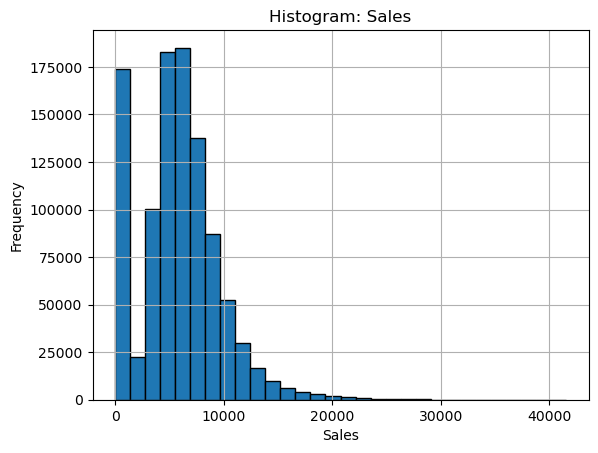

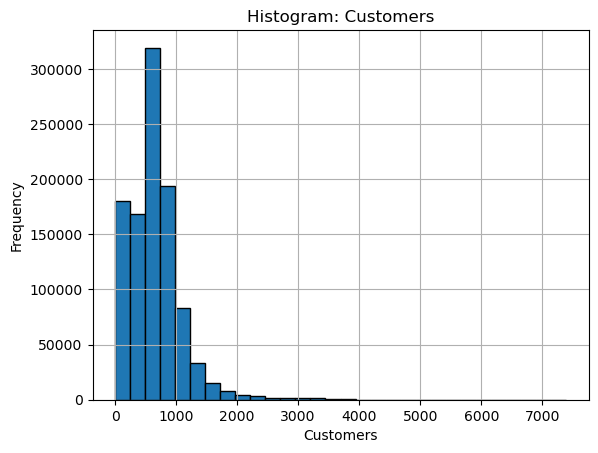

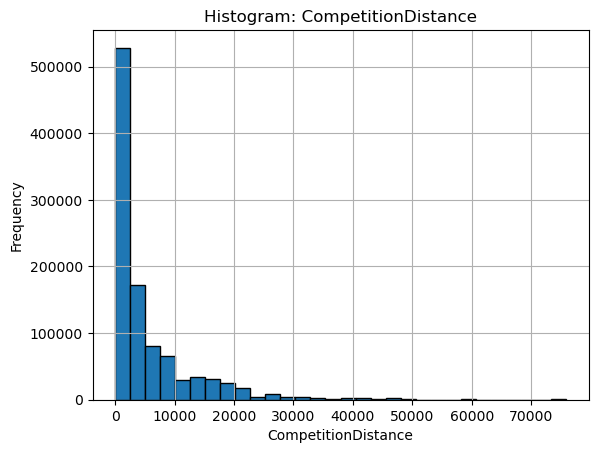

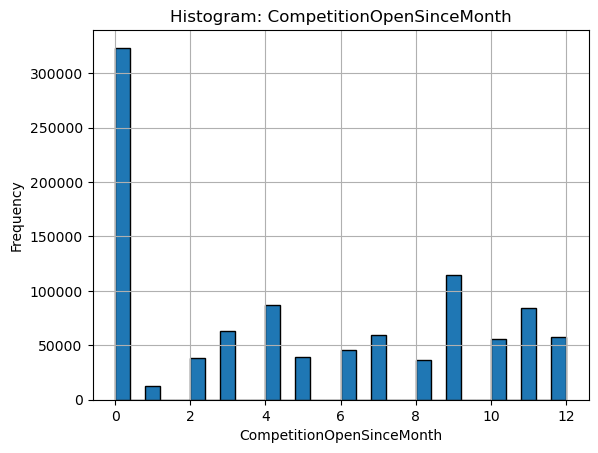

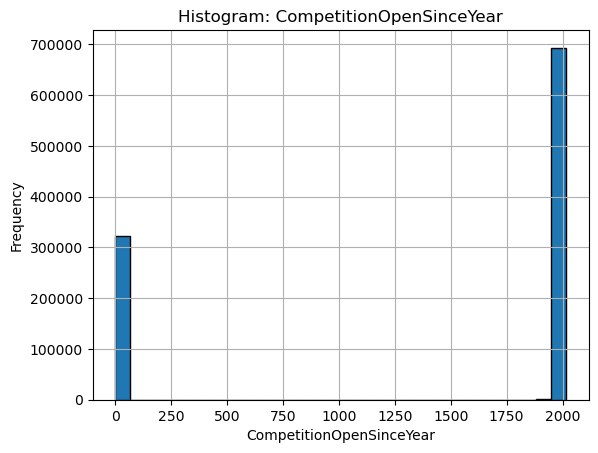

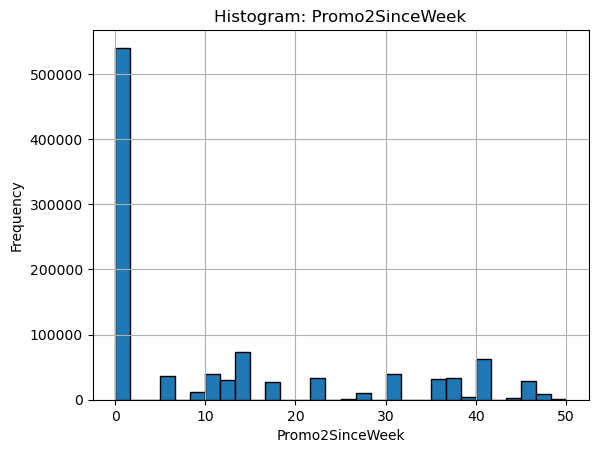

TL;DR: Plotted histograms for numeric features.


In [80]:
# EDA: distributions (histograms)

if not num_cols:
    print('Warning: No numeric columns for histograms.')
else:
    for c in num_cols:
        plt.figure()
        df[c].dropna().hist(bins=30, edgecolor='black')
        plt.title(f'Histogram: {c}')
        plt.xlabel(c)
        plt.ylabel('Frequency')
        plt.show()
print('TL;DR: Plotted histograms for numeric features.')

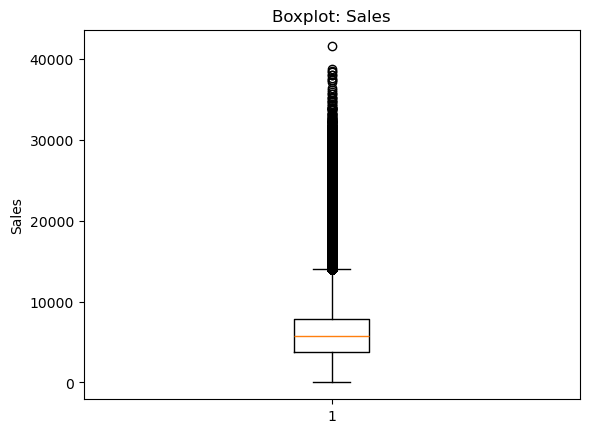

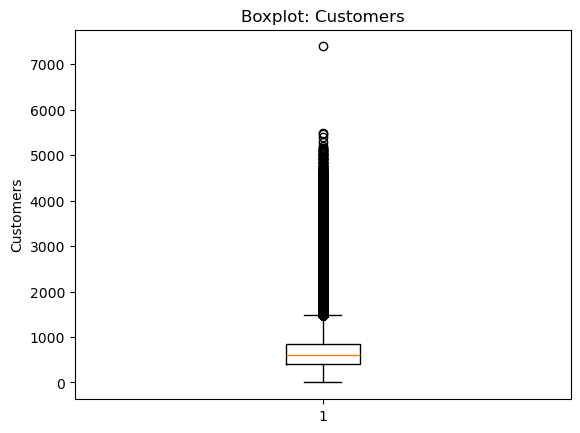

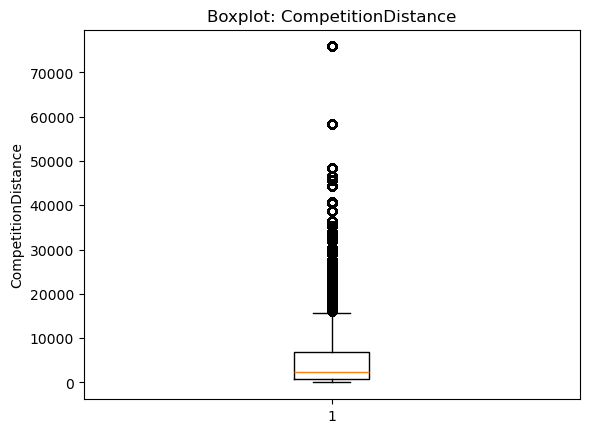

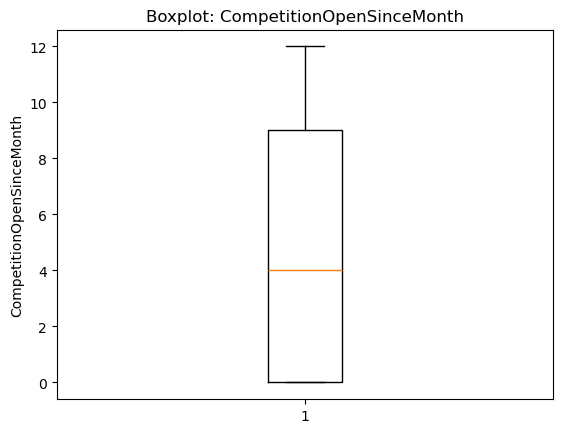

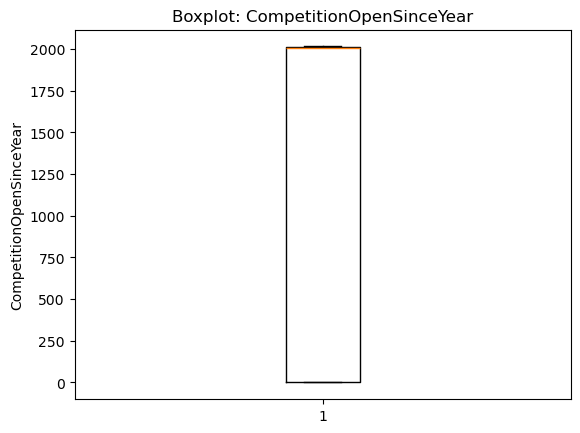

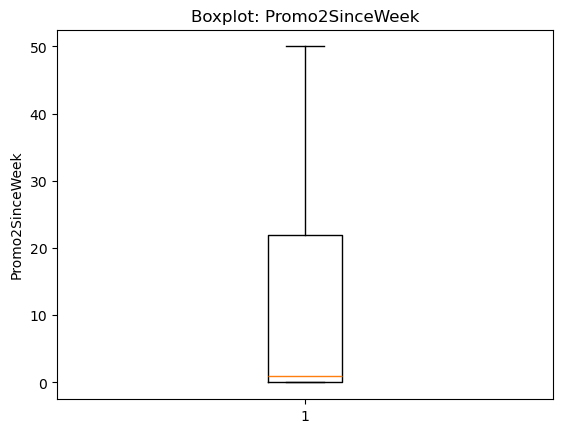

TL;DR: Boxplots highlight spread and potential outliers.


In [81]:
# EDA: boxplots

if not num_cols:
    print('Warning: No numeric columns for boxplots.')
else:
    for c in num_cols:
        plt.figure()
        plt.boxplot(df[c].dropna(), vert=True)
        plt.title(f'Boxplot: {c}')
        plt.ylabel(c)
        plt.show()
print('TL;DR: Boxplots highlight spread and potential outliers.')

,Sales,Customers,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2SinceWeek
Sales,1.000000,0.894711,-0.018609,-0.012431,0.002749,-0.044143
Customers,0.894711,1.000000,-0.102022,-0.015188,0.000489,-0.098323
CompetitionDistance,-0.018609,-0.102022,1.000000,-0.032274,-0.000212,-0.122348
CompetitionOpenSinceMonth,-0.012431,-0.015188,-0.032274,1.000000,0.784968,-0.108546
CompetitionOpenSinceYear,0.002749,0.000489,-0.000212,0.784968,1.000000,-0.124378
Promo2SinceWeek,-0.044143,-0.098323,-0.122348,-0.108546,-0.124378,1.000000


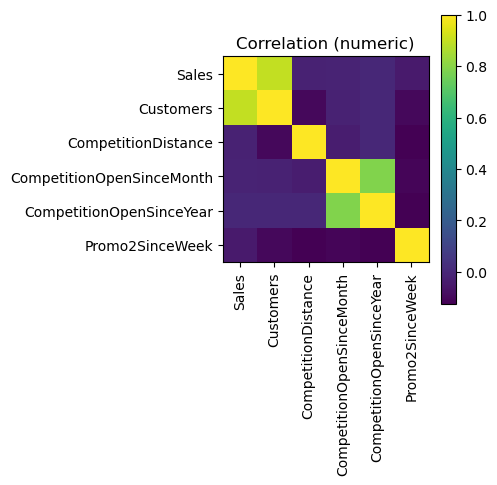

TL;DR: Shown correlation matrix and heatmap for numeric features.


In [82]:
# EDA: correlation matrix (numeric only)

if not num_cols or len(num_cols) < 2:
    print('Warning: Not enough numeric columns for correlation.')
else:
    corr = df[num_cols].corr(numeric_only=True)
    display(corr)
    plt.figure(figsize=(min(10, 0.5*len(num_cols)+2), min(8, 0.5*len(num_cols)+2)))
    im = plt.imshow(corr.values, cmap='viridis')
    plt.colorbar(im)
    plt.xticks(ticks=range(len(num_cols)), labels=num_cols, rotation=90)
    plt.yticks(ticks=range(len(num_cols)), labels=num_cols)
    plt.title('Correlation (numeric)')
    plt.tight_layout()
    plt.show()
print('TL;DR: Shown correlation matrix and heatmap for numeric features.')

In [83]:
# EDA: target-aware analysis

if TARGET_COL and (TARGET_COL in df.columns):
    if pd.api.types.is_numeric_dtype(df[TARGET_COL]):
        # correlation of target with numeric features
        feats = [c for c in num_cols if c != TARGET_COL]
        if feats:
            tgt_corr = df[feats + [TARGET_COL]].corr()[TARGET_COL].drop(TARGET_COL).sort_values(ascending=False)
            display(tgt_corr.to_frame('corr_with_target'))
            print('Top 5 by absolute corr:')
            display(tgt_corr.abs().sort_values(ascending=False).head(5).to_frame('abs_corr'))
        else:
            print('Warning: No numeric features besides target for correlation.')
    else:
        # class distribution and numeric means per class
        vc = df[TARGET_COL].value_counts(dropna=False)
        share = (vc/len(df)*100).round(2)
        display(pd.DataFrame({'count': vc, 'share_%': share}))
        if num_cols:
            means = df.groupby(TARGET_COL)[num_cols].mean().T.sort_index()
            display(means.head(5))
        else:
            print('Warning: No numeric columns to summarize by class.')
else:
    print('Warning: TARGET_COL not set or not found; skipping target-aware EDA.')
print('TL;DR: Target-aware summary shown depending on target type.')

TL;DR: Target-aware summary shown depending on target type.


In [84]:
# EDA: outliers via IQR per numeric column

if not num_cols:
    print('Warning: No numeric columns for outlier check.')
else:
    rows = []
    for c in num_cols:
        s = df[c].dropna()
        if s.empty:
            rows.append({'column': c, 'outlier_count': 0})
            continue
        q1 = s.quantile(0.25)
        q3 = s.quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5*iqr
        upper = q3 + 1.5*iqr
        cnt = int(((s < lower) | (s > upper)).sum())
        rows.append({'column': c, 'outlier_count': cnt})
    out_df = pd.DataFrame(rows).sort_values('outlier_count', ascending=False)
    display(out_df)
print('TL;DR: Counted IQR outliers per numeric column.')

,column,outlier_count
2,CompetitionDistance,99160
1,Customers,38095
0,Sales,26694
3,CompetitionOpenSinceMonth,0
4,CompetitionOpenSinceYear,0
5,Promo2SinceWeek,0


TL;DR: Counted IQR outliers per numeric column.


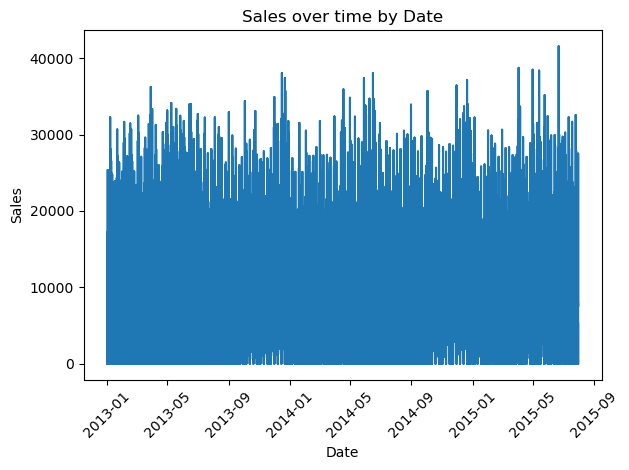

TL;DR: Plotted simple time trend if datetime & numeric columns available.


In [85]:
# EDA: datetime trend (first numeric vs first datetime)

dt_cols_parsed = [c for c in (DATETIME_COLS or []) if c in df.columns and pd.api.types.is_datetime64_any_dtype(df[c])] if df is not None else []
if dt_cols_parsed and num_cols:
    dcol = dt_cols_parsed[0]
    ncol = num_cols[0] if num_cols[0] != TARGET_COL else (num_cols[1] if len(num_cols)>1 else None)
    if ncol:
        ts = df[[dcol, ncol]].dropna()
        ts = ts.sort_values(dcol)
        plt.figure()
        plt.plot(ts[dcol], ts[ncol])
        plt.title(f'{ncol} over time by {dcol}')
        plt.xlabel(dcol)
        plt.ylabel(ncol)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print('Warning: Not enough numeric columns to plot time trend.')
else:
    print('Warning: No parsed datetime columns or numeric columns for time trend.')
print('TL;DR: Plotted simple time trend if datetime & numeric columns available.')

In [86]:
# Load / outputs: save cleaned data and summaries
import os
paths = {}
if df is None:
    print('Warning: df is None; nothing to save.')
else:
    os.makedirs('../data/etl_outputs', exist_ok=True)
    # Save full cleaned parquet
    p_parquet = '../data/etl_outputs/clean_data.parquet'
    try:
        df.to_parquet(p_parquet, index=False)
        paths['parquet'] = p_parquet
    except Exception as e:
        print(f'Warning: parquet save failed: {e}')
    # Save sample CSV (first 10k rows)
    p_sample = '../data/etl_outputs/clean_data_sample.csv'
    df.head(10_000).to_csv(p_sample, index=False)
    paths['sample_csv'] = p_sample
    # Save numeric summary
    if 'num_cols' in globals() and num_cols:
        p_num = '../data/etl_outputs/numeric_summary.csv'
        df[num_cols].describe().T.to_csv(p_num)
        paths['numeric_summary'] = p_num
    # Save missing summary
    if 'missing_df' in globals():
        p_miss = '../data/etl_outputs/missing_summary.csv'
        missing_df.to_csv(p_miss)
        paths['missing_summary'] = p_miss
    print('Saved files:')
    for k,v in paths.items():
        print(f'  {k}: {v}')
    print('Rows saved (parquet target if available, else CSV sample):', len(df))
print('TL;DR: Persisted cleaned data and summaries to ../data/etl_outputs.')

Saved files:
  parquet: ../data/etl_outputs/clean_data.parquet
  sample_csv: ../data/etl_outputs/clean_data_sample.csv
  numeric_summary: ../data/etl_outputs/numeric_summary.csv
  missing_summary: ../data/etl_outputs/missing_summary.csv
Rows saved (parquet target if available, else CSV sample): 1017209
TL;DR: Persisted cleaned data and summaries to ../data/etl_outputs.


In [87]:
# Ensure 'Open' is numeric and filter to Open == 1
if 'Open' not in df.columns:
    print("Warning: 'Open' column not found; skipping filter.")
else:
    print('Open value_counts before:')
    print(df['Open'].value_counts(dropna=False).sort_index())
    # Coerce to numeric to handle strings like '0'/'1'
    coerced = pd.to_numeric(df['Open'], errors='coerce')
    newly_nan = int(coerced.isna().sum() - df['Open'].isna().sum())
    if newly_nan > 0:
        print(f'Warning: {newly_nan} values became NaN during numeric coercion.')
    df['Open'] = coerced
    before_len = len(df)
    df = df[df['Open'] == 1].copy()
    dropped = before_len - len(df)
    print(f'Dropped rows where Open != 1: {dropped}')
    print('Open value_counts after:')
    print(df['Open'].value_counts(dropna=False).sort_index())
print('TL;DR: Coerced Open to numeric and kept rows with Open == 1.')

Open value_counts before:
Open
0    172817
1    844392
Name: count, dtype: int64
Dropped rows where Open != 1: 172817
Open value_counts after:
Open
1    844392
Name: count, dtype: int64
TL;DR: Coerced Open to numeric and kept rows with Open == 1.
Dropped rows where Open != 1: 172817
Open value_counts after:
Open
1    844392
Name: count, dtype: int64
TL;DR: Coerced Open to numeric and kept rows with Open == 1.


In [88]:
# Verify 'Open' filtering result
if 'Open' in df.columns:
    print('Unique values in Open:', sorted(df['Open'].dropna().unique().tolist()))
    print('Counts:')
    print(df['Open'].value_counts(dropna=False).sort_index())
    if (df['Open'] == 0).any():
        print('Warning: Zero values still present in Open after filtering.')
    else:
        print('No zeros remain in Open.')
else:
    print("Warning: 'Open' column not found.")
print('TL;DR: Checked Open values post-filter.')

Unique values in Open: [1]
Counts:
Open
1    844392
Name: count, dtype: int64
No zeros remain in Open.
TL;DR: Checked Open values post-filter.


In [89]:
df.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
606916,27,5,2014-01-03,8297,1093,1,0,0,1,a,a,60.0,1.0,2005.0,1,5.0,2011.0,"Jan,Apr,Jul,Oct"
485850,496,2,2014-04-22,6407,769,1,0,0,1,d,c,2780.0,6.0,2015.0,0,0.0,Unknown,Unknown
536306,777,6,2014-03-08,3941,363,1,0,0,0,d,c,8250.0,10.0,2004.0,1,10.0,2013.0,"Mar,Jun,Sept,Dec"
308050,735,4,2014-10-16,4041,469,1,0,0,0,d,c,1920.0,4.0,2005.0,0,0.0,Unknown,Unknown
257357,483,2,2014-12-09,6466,878,1,0,0,0,a,c,2310.0,9.0,2011.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


<Axes: xlabel='Sales', ylabel='Count'>

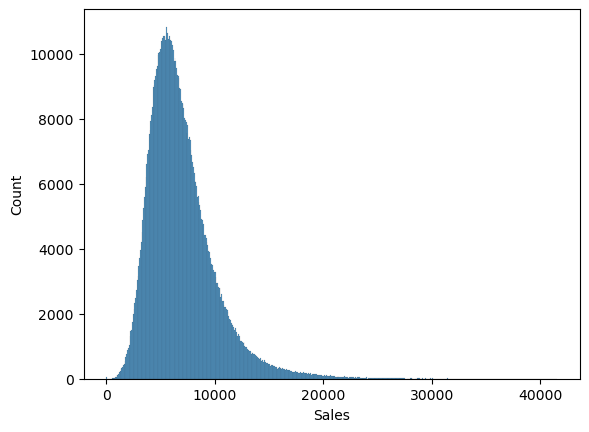

In [90]:
sns.histplot(df, x='Sales')

<Axes: xlabel='DayOfWeek', ylabel='Sales'>

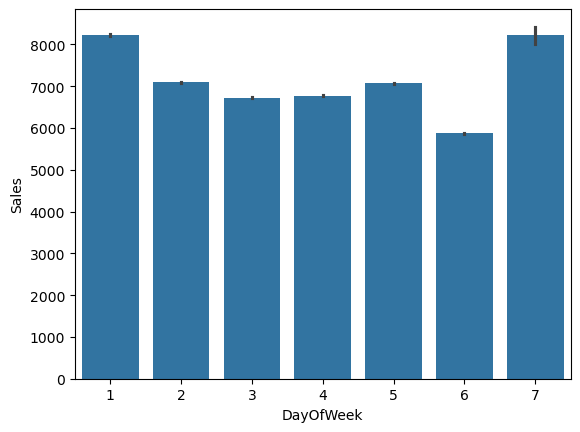

In [91]:
sns.barplot(df, x='DayOfWeek', y='Sales')

<Axes: xlabel='Promo', ylabel='Sales'>

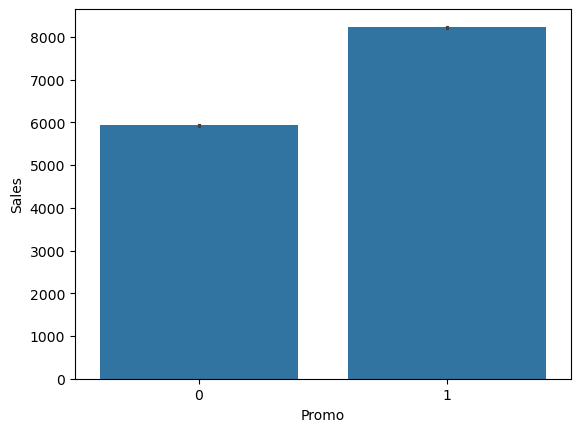

In [92]:
sns.barplot(data=df, x='Promo', y='Sales')